Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# FineTuning NLP Models with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use the FLAML library to fine tune an NLP language model with hyperparameter search. We have tested this notebook on a server with 4 NVidia V100 GPU (32GB) and 400GB CPU Ram.

FLAML requires `Python>=3.7`. To run this notebook example, please install flaml with the `nlp,ray,notebook` and `blendsearch` option:
```bash
pip install flaml[nlp,ray,notebook,blendsearch];
```

In [1]:
%pip install flaml[nlp,ray,notebook,blendsearch]

Note: you may need to restart the kernel to use updated packages.


Let's run some examples. 

Note: throughout this notebook, you may see a few ModuleNotFoundErrors. As long as the cell successfully executes, you can ignore that error.

## 2. Sentiment Classification Example
### Load data and preprocess

The Stanford Sentiment treebank (SST-2) dataset is a dataset for sentiment classification. First, let's load this dataset into pandas dataframes:

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split="train").to_pandas()
dev_dataset = load_dataset("glue", "sst2", split="validation").to_pandas()
test_dataset = load_dataset("glue", "sst2", split="test").to_pandas()

Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Reusing dataset glue (/home/xliu127/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Take a look at the first 5 examples of this dataset:

In [3]:
train_dataset.head(5)

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


Separate the data into X and y:

In [2]:
custom_sent_keys = ["sentence"]          # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

### Run FLAML

In [3]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
if not ray.is_initialized():
    ray.init() 

/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2022-08-13 16:52:12,092	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


In [4]:
TIME_BUDGET=1800
automl_settings = {
    "time_budget": TIME_BUDGET,                  # setting the time budget
    "task": "seq-classification",       # setting the task as seq-classification
    "fit_kwargs_by_estimator": {
        "transformer": {
            "output_dir": "data/output/",   # setting the output directory
            "model_path": "google/electra-small-discriminator",  # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
        }
    },
    "gpu_per_trial": 1,                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
    "n_concurrent_trials": 4,
    "keep_search_state": True,          # keeping the search state
}

In [5]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=49559) {'loss': 0.1493, 'learning_rate': 9.269681649947959e-06, 'epoch': 2.26}
(train pid=50106) {'eval_loss': 0.3011920750141144, 'eval_automl_metric': 0.09633027522935778, 'eval_runtime': 6.9816, 'eval_samples_per_second': 124.899, 'eval_steps_per_second': 124.899, 'epoch': 2.0}
(train pid=50265) {'loss': 0.1551, 'learning_rate': 3.2693767566133266e-05, 'epoch': 1.9}
(train pid=50443) {'loss': 0.2014, 'learning_rate': 1.2879756568772649e-05, 'epoch': 1.43}
(train pid=50106) {'loss': 0.1524, 'learning_rate': 7.4163905463114075e-06, 'epoch': 2.14}
(train pid=50265) {'eval_loss': 0.3561520278453827, 'eval_automl_metric': 0.11238532110091748, 'eval_runtime': 7.1398, 'eval_samples_per_second': 122.133, 'eval_steps_per_second': 122.133, 'epoch': 2.0}
(train pid=49559) {'loss': 0.1492, 'learning_rate': 7.788901833662341e-06, 'epoch': 2.38}
(train pid=50265) {'loss': 0.1292, 'learning_rate': 2.5632478674959775e-05, 'epoch': 2.14}
(train pid=50443) {'loss': 0.1936, 'learning_rate':

(train pid=50106) ***** Running Prediction *****
(train pid=50106)   Num examples = 872
(train pid=50106)   Batch size = 1
(train pid=50106) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_80bc1972_47_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-13_17-17-39/checkpoint-6315/added_tokens.json. We won't load it.
(train pid=50106) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_80bc1972_47_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-13_17-17-39/checkpoint-6315/vocab.txt
(train pid=50106) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_80bc1972_47_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-13_17

(train pid=50265) {'eval_loss': 0.3420582413673401, 'eval_automl_metric': 0.09633027522935778, 'eval_runtime': 8.4313, 'eval_samples_per_second': 103.424, 'eval_steps_per_second': 103.424, 'epoch': 3.0}
(train pid=50265) {'train_runtime': 404.0512, 'train_samples_per_second': 500.053, 'train_steps_per_second': 15.629, 'train_loss': 0.18374049291663574, 'epoch': 3.0}


(train pid=50265) ***** Running Prediction *****
(train pid=50265)   Num examples = 872
(train pid=50265)   Batch size = 1


(train pid=50443) {'loss': 0.1614, 'learning_rate': 6.938909442955006e-06, 'epoch': 2.61}


(train pid=50265) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_918542ec_48_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train__2022-08-13_17-18-07/checkpoint-6315/added_tokens.json. We won't load it.
(train pid=50265) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_918542ec_48_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train__2022-08-13_17-18-07/checkpoint-6315/vocab.txt
(train pid=50265) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_918542ec_48_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train__2022-08-13_17-18-07/checkpoint-6315/tokenizer.json
(train pid=50265) loading file None
(train pid=50265) loading file /data/xliu127/proj

(train pid=49559) {'loss': 0.136, 'learning_rate': 3.8500275223426025e-07, 'epoch': 2.97}
(train pid=49559) {'eval_loss': 0.3623480498790741, 'eval_automl_metric': 0.08600917431192656, 'eval_runtime': 6.9268, 'eval_samples_per_second': 125.888, 'eval_steps_per_second': 125.888, 'epoch': 3.0}
(train pid=49559) {'train_runtime': 794.5838, 'train_samples_per_second': 254.28, 'train_steps_per_second': 15.895, 'train_loss': 0.20292378529045002, 'epoch': 3.0}


(train pid=49559) ***** Running Prediction *****
(train pid=49559)   Num examples = 872
(train pid=49559)   Batch size = 1


(train pid=50443) {'loss': 0.1528, 'learning_rate': 5.750740017791478e-06, 'epoch': 2.85}


(train pid=49559) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_bbde8ec8_45_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-13_17-12-09/checkpoint-12630/added_tokens.json. We won't load it.
(train pid=49559) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_bbde8ec8_45_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-13_17-12-09/checkpoint-12630/vocab.txt
(train pid=49559) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_bbde8ec8_45_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-13_17-12-09/checkpoint-12630/tokenizer.json
(train pid=49559) loading file None
(train pid=49559) loading file /data/xliu127/p

(train pid=50443) {'eval_loss': 0.29546257853507996, 'eval_automl_metric': 0.08830275229357798, 'eval_runtime': 7.0421, 'eval_samples_per_second': 123.827, 'eval_steps_per_second': 123.827, 'epoch': 3.0}
(train pid=50443) {'loss': 0.1462, 'learning_rate': 4.56257059262795e-06, 'epoch': 3.09}
(train pid=50443) {'loss': 0.1474, 'learning_rate': 3.374401167464421e-06, 'epoch': 3.33}
(train pid=50443) {'loss': 0.134, 'learning_rate': 2.1862317423008924e-06, 'epoch': 3.56}
(train pid=50443) {'loss': 0.138, 'learning_rate': 9.98062317137364e-07, 'epoch': 3.8}
(train pid=50443) {'eval_loss': 0.32222986221313477, 'eval_automl_metric': 0.09518348623853212, 'eval_runtime': 7.0713, 'eval_samples_per_second': 123.315, 'eval_steps_per_second': 123.315, 'epoch': 4.0}
(train pid=50443) {'train_runtime': 539.1601, 'train_samples_per_second': 499.659, 'train_steps_per_second': 15.617, 'train_loss': 0.2059766846428008, 'epoch': 4.0}


(train pid=50443) ***** Running Prediction *****
(train pid=50443)   Num examples = 872
(train pid=50443)   Batch size = 1
(train pid=50443) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_b7e08512_49_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-13_17-19-11/checkpoint-6315/added_tokens.json. We won't load it.
(train pid=50443) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_b7e08512_49_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-13_17-19-11/checkpoint-6315/vocab.txt
(train pid=50443) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-08-13_16-52-17/train_b7e08512_49_FLAML_sample_size=67349,global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train__2022-08-13_17

{'loss': 0.417, 'learning_rate': 3.55863617139559e-05, 'epoch': 0.24}
{'loss': 0.2872, 'learning_rate': 3.252648538429503e-05, 'epoch': 0.48}
{'loss': 0.2452, 'learning_rate': 2.9466609054634162e-05, 'epoch': 0.71}
{'loss': 0.2204, 'learning_rate': 2.6406732724973297e-05, 'epoch': 0.95}
{'loss': 0.1823, 'learning_rate': 2.334685639531243e-05, 'epoch': 1.19}
{'loss': 0.1743, 'learning_rate': 2.0286980065651558e-05, 'epoch': 1.43}
{'loss': 0.1662, 'learning_rate': 1.722710373599069e-05, 'epoch': 1.66}
{'loss': 0.1674, 'learning_rate': 1.416722740632982e-05, 'epoch': 1.9}
{'loss': 0.1422, 'learning_rate': 1.1107351076668952e-05, 'epoch': 2.14}
{'loss': 0.1271, 'learning_rate': 8.047474747008085e-06, 'epoch': 2.38}
{'loss': 0.123, 'learning_rate': 4.987598417347216e-06, 'epoch': 2.61}
{'loss': 0.1209, 'learning_rate': 1.927722087686347e-06, 'epoch': 2.85}


[flaml.automl: 08-13 17:36:12] {3465} INFO - retrain transformer for 440.2s
[flaml.automl: 08-13 17:36:12] {3472} INFO - retrained model: None
[flaml.automl: 08-13 17:36:12] {2749} INFO - fit succeeded
[flaml.automl: 08-13 17:36:12] {2750} INFO - Time taken to find the best model: 1610.794395685196
[flaml.automl: 08-13 17:36:12] {2761} WARNING - Time taken to find the best model is 89% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.


{'train_runtime': 415.3339, 'train_samples_per_second': 486.469, 'train_steps_per_second': 15.205, 'train_loss': 0.194211708848097, 'epoch': 3.0}


In [6]:
print("The best loss by FLAML: {}".format(automl.best_loss))

The best loss by FLAML: 0.07798165137614677


### Best model and metric

In [6]:
'''retrieve best config and best learner'''
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'learning_rate': 1.4736175808553141e-05, 'num_train_epochs': 7.623375372739029, 'per_device_train_batch_size': 16, 'warmup_ratio': 0.21605876280261357, 'weight_decay': 0.11938244526496489, 'adam_epsilon': 7.353322403647365e-07, 'seed': 42, 'global_max_steps': 1878, 'learner': 'transformer'}
Best accuracy on validation data: 0.9404
Training duration of best run: 157.7 s


In [8]:
import pickle
automl.pickle("automl.pkl")

with open("automl.pkl", "rb") as f:
    automl = pickle.load(f)

/data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.528, 'learning_rate': 8.898933352349567e-06, 'epoch': 1.0}
{'eval_loss': 0.2549280524253845, 'eval_automl_metric': 0.08600917431192656, 'eval_runtime': 1.0003, 'eval_samples_per_second': 871.751, 'eval_steps_per_second': 54.984, 'epoch': 1.0}
{'loss': 0.2278, 'learning_rate': 1.3880017803076292e-05, 'epoch': 2.0}
{'eval_loss': 0.24966619908809662, 'eval_automl_metric': 0.06766055045871555, 'eval_runtime': 1.0201, 'eval_samples_per_second': 854.778, 'eval_steps_per_second': 53.914, 'epoch': 2.0}
{'loss': 0.1455, 'learning_rate': 1.1410179501562432e-05, 'epoch': 3.0}
{'eval_loss': 0.23046882450580597, 'eval_automl_metric': 0.059633027522935755, 'eval_runtime': 1.0097, 'eval_samples_per_second': 863.6, 'eval_steps_per_second': 54.47, 'epoch': 3.0}
{'eval_loss': 0.23046882450580597, 'eval_automl_metric': 0.059633027522935755, 'eval_runtime': 0.9726, 'eval_samples_per_second': 896.568, 'eval_steps_per_second': 56.55, 'epoch': 3.0}
{'train_runtime': 146.7879, 'train_samples_per_se

Using amp half precision backend
***** Running Prediction *****
  Num examples = 872
  Batch size = 64


In [9]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test, **{"per_device_eval_batch_size": 1})
print('Predicted labels', y_pred)

Using amp half precision backend
***** Running Prediction *****
  Num examples = 1821
  Batch size = 4


Predicted labels [0 0 1 ... 1 1 1]


### Log history

In [10]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 313, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, 'global_max_steps': 313, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.4211966209891772e-05, 'num_train_epochs': 0.22667066737595704, 'per_device_train_batch_size': 4, 'warmup_ratio': 0.0638407085008166, 'weight_decay': 0.24365576482793252, 'adam_epsilon': 1.2017005181798623e-08, 'seed': 44, 'global_max_steps': 567, 'learner': 'transformer'}, 'Best Learne

10


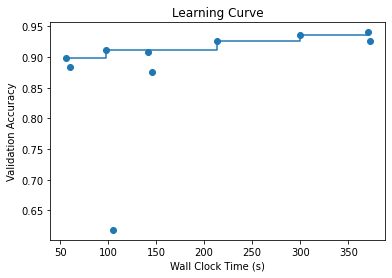

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Spooky-author-identification example

In [1]:
from flaml import AutoML
import ray
import pandas as pd
from sklearn.model_selection import train_test_split
ray.init(num_cpus=4, num_gpus=4, ignore_reinit_error=True)

df = pd.read_csv('/data/xliu127/projects/hyperopt/FLAML/data/spooky-author-identification.csv')
X, y = df.drop('author', axis=1), df['author']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=123)


print(len(X_train), len(X_val))
automl_model = AutoML()

automl_settings = {
    "time_budget": 1800,                 
    "task": "seq-classification",       
    "fit_kwargs_by_estimator": {
        "transformer": {
            "output_dir": "data/output/",   
            "model_path": "bert-base-uncased",  
        }
    },
    "metric": "accuracy",
    "gpu_per_trial": 1,  
    "log_file_name": "spooky_bert.log", 
    "log_type": "all",                 
    "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
    "n_concurrent_trials": 4,
    "keep_search_state": True,          # keeping the search state
}

automl_model.fit(X_train=X_train, y_train=y_train,X_val=X_val, y_val=y_val, **automl_settings)

(train pid=78542) {'train_runtime': 675.882, 'train_samples_per_second': 108.628, 'train_steps_per_second': 6.791, 'train_loss': 0.15587145374491324, 'epoch': 5.0}


(train pid=78542) The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=78542) ***** Running Prediction *****
(train pid=78542)   Num examples = 4895
(train pid=78542)   Batch size = 1


(train pid=78793) {'eval_loss': 0.47973549365997314, 'eval_automl_metric': 0.12134831460674156, 'eval_runtime': 42.4421, 'eval_samples_per_second': 115.334, 'eval_steps_per_second': 115.334, 'epoch': 4.0}
(train pid=78793) {'train_runtime': 482.2078, 'train_samples_per_second': 121.806, 'train_steps_per_second': 1.908, 'train_loss': 0.23729169679724652, 'epoch': 4.0}


(train pid=78793) The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=78793) ***** Running Prediction *****
(train pid=78793)   Num examples = 4895
(train pid=78793)   Batch size = 1


(train pid=78225) {'loss': 0.1844, 'learning_rate': 2.7020242630660653e-06, 'epoch': 3.0}


(train pid=78542) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_e041e7d6_10_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=5,per_device_trai_2022-07-22_07-09-19/checkpoint-4590/added_tokens.json. We won't load it.
(train pid=78542) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_e041e7d6_10_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=5,per_device_trai_2022-07-22_07-09-19/checkpoint-4590/vocab.txt
(train pid=78542) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_e041e7d6_10_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=5,per_device_trai_2022-07-22_07-09-19/checkpoint-4590/tokenizer.json
(train pid=78542) loading file None
(train pid=78542) loading file /data/xliu127/proj

(train pid=78225) {'eval_loss': 0.7813186049461365, 'eval_automl_metric': 0.13564862104187947, 'eval_runtime': 38.0461, 'eval_samples_per_second': 128.66, 'eval_steps_per_second': 128.66, 'epoch': 3.0}
(train pid=78225) {'loss': 0.0829, 'learning_rate': 2.3353000145500413e-06, 'epoch': 3.13}
(train pid=79025) {'eval_loss': 0.5877022743225098, 'eval_automl_metric': 0.11848825331971402, 'eval_runtime': 40.6459, 'eval_samples_per_second': 120.43, 'eval_steps_per_second': 120.43, 'epoch': 4.0}
(train pid=78225) {'loss': 0.0714, 'learning_rate': 1.9685757660340173e-06, 'epoch': 3.27}
(train pid=79025) {'loss': 0.0237, 'learning_rate': 3.91430499829805e-06, 'epoch': 4.36}
(train pid=78225) {'loss': 0.0584, 'learning_rate': 1.6018515175179931e-06, 'epoch': 3.41}
(train pid=78225) {'loss': 0.0836, 'learning_rate': 1.235127269001969e-06, 'epoch': 3.54}
(train pid=78225) {'loss': 0.0335, 'learning_rate': 8.684030204859451e-07, 'epoch': 3.68}
(train pid=79025) {'eval_loss': 0.6322397589683533, 'e

(train pid=79025) The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=79025) ***** Running Prediction *****
(train pid=79025)   Num examples = 4895
(train pid=79025)   Batch size = 1


(train pid=78225) {'loss': 0.0562, 'learning_rate': 5.01678771969921e-07, 'epoch': 3.81}


(train pid=79025) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_9a34cd4a_12_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=5,per_device_trai_2022-07-22_07-14-32/checkpoint-2295/added_tokens.json. We won't load it.
(train pid=79025) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_9a34cd4a_12_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=5,per_device_trai_2022-07-22_07-14-32/checkpoint-2295/vocab.txt
(train pid=79025) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_9a34cd4a_12_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=5,per_device_trai_2022-07-22_07-14-32/checkpoint-2295/tokenizer.json
(train pid=79025) loading file None
(train pid=79025) loading file /data/xliu127/proj

(train pid=78225) {'loss': 0.0527, 'learning_rate': 1.3495452345389687e-07, 'epoch': 3.95}
(train pid=78225) {'eval_loss': 0.8104404211044312, 'eval_automl_metric': 0.12625127681307458, 'eval_runtime': 37.4885, 'eval_samples_per_second': 130.573, 'eval_steps_per_second': 130.573, 'epoch': 4.0}
(train pid=78225) {'train_runtime': 1051.1951, 'train_samples_per_second': 55.875, 'train_steps_per_second': 13.969, 'train_loss': 0.2927411694969607, 'epoch': 4.0}


(train pid=78225) The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=78225) ***** Running Prediction *****
(train pid=78225)   Num examples = 4895
(train pid=78225)   Batch size = 1
(train pid=78225) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_d0e0b7d6_9_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_train_2022-07-22_07-08-52/checkpoint-14684/added_tokens.json. We won't load it.
(train pid=78225) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-22_06-50-38/train_d0e0b7d6_9_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_train_2022-07-

{'loss': 0.2317, 'learning_rate': 5.95732076822092e-06, 'epoch': 4.35}


[flaml.automl: 07-22 07:35:19] {3457} INFO - retrain transformer for 474.4s
[flaml.automl: 07-22 07:35:19] {3464} INFO - retrained model: None
[flaml.automl: 07-22 07:35:19] {2742} INFO - fit succeeded
[flaml.automl: 07-22 07:35:19] {2743} INFO - Time taken to find the best model: 1118.247492313385


{'train_runtime': 463.5873, 'train_samples_per_second': 158.374, 'train_steps_per_second': 1.24, 'train_loss': 0.20362980179164722, 'epoch': 5.0}


In [2]:
print("the best loss for spooky author identification: {}".format(automl_model.best_loss))

the best loss for spooky author identification: 0.11133810010214507


In [ ]:
automl_settings["fit_kwargs_by_estimator"]["transformer"]["model_path"] = "roberta-base"
automl_settings["log_file_name"] = "spooky_roberta.log"
automl_model.fit(X_train=X_train, y_train=y_train,X_val=X_val, y_val=y_val, **automl_settings)

(train pid=50245) {'eval_loss': 0.7418951392173767, 'eval_automl_metric': 0.1284984678243105, 'eval_runtime': 37.3935, 'eval_samples_per_second': 130.905, 'eval_steps_per_second': 130.905, 'epoch': 4.0}
(train pid=50245) {'train_runtime': 565.7729, 'train_samples_per_second': 103.816, 'train_steps_per_second': 6.49, 'train_loss': 0.2802804773409642, 'epoch': 4.0}


(train pid=50245) The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=50245) ***** Running Prediction *****
(train pid=50245)   Num examples = 4895
(train pid=50245)   Batch size = 1


(train pid=50412) {'eval_loss': 1.0893423557281494, 'eval_automl_metric': 0.6024514811031665, 'eval_runtime': 39.7178, 'eval_samples_per_second': 123.245, 'eval_steps_per_second': 123.245, 'epoch': 3.0}
(train pid=50658) {'loss': 0.2369, 'learning_rate': 1.4090340380281214e-05, 'epoch': 2.72}
(train pid=50412) {'train_runtime': 566.9953, 'train_samples_per_second': 77.694, 'train_steps_per_second': 9.714, 'train_loss': 1.0928592581461545, 'epoch': 3.0}
(train pid=49988) {'eval_loss': 1.092341661453247, 'eval_automl_metric': 0.6024514811031665, 'eval_runtime': 38.0057, 'eval_samples_per_second': 128.797, 'eval_steps_per_second': 128.797, 'epoch': 3.0}


(train pid=50412) The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=50412) ***** Running Prediction *****
(train pid=50412)   Num examples = 4895
(train pid=50412)   Batch size = 1
(train pid=50245) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_60247332_10_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_2022-07-21_21-11-36/checkpoint-3672/added_tokens.json. We won't load it.
(train pid=50245) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_60247332_10_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=4,per_device_trai_202

(train pid=49988) {'loss': 1.0896, 'learning_rate': 1.5104688589428795e-05, 'epoch': 3.13}


(train pid=50412) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_6861ba34_11_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=3,per_device_trai_2022-07-21_21-11-51/checkpoint-3672/added_tokens.json. We won't load it.
(train pid=50412) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_6861ba34_11_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=3,per_device_trai_2022-07-21_21-11-51/checkpoint-3672/vocab.json
(train pid=50412) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_6861ba34_11_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=3,per_device_trai_2022-07-21_21-11-51/checkpoint-3672/merges.txt
(train pid=50412) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/outpu

(train pid=50658) {'loss': 0.2195, 'learning_rate': 1.2404892966371977e-05, 'epoch': 3.0}
(train pid=49988) {'loss': 1.0907, 'learning_rate': 1.2732721160184323e-05, 'epoch': 3.27}
(train pid=50658) {'loss': 0.1252, 'learning_rate': 1.0719445552462741e-05, 'epoch': 3.27}
(train pid=49988) {'loss': 1.0926, 'learning_rate': 1.0360753730939852e-05, 'epoch': 3.41}
(train pid=50658) {'loss': 0.1093, 'learning_rate': 9.033998138553504e-06, 'epoch': 3.54}
(train pid=49988) {'loss': 1.0908, 'learning_rate': 7.988786301695379e-06, 'epoch': 3.54}
(train pid=50658) {'loss': 0.1166, 'learning_rate': 7.348550724644269e-06, 'epoch': 3.81}
(train pid=49988) {'loss': 1.0899, 'learning_rate': 5.616818872450909e-06, 'epoch': 3.68}
(train pid=49988) {'loss': 1.0923, 'learning_rate': 3.244851443206437e-06, 'epoch': 3.81}
(train pid=50658) {'eval_loss': 0.7831101417541504, 'eval_automl_metric': 0.13462717058222673, 'eval_runtime': 37.9679, 'eval_samples_per_second': 128.925, 'eval_steps_per_second': 128.92

(train pid=49988) The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=49988) ***** Running Prediction *****
(train pid=49988)   Num examples = 4895
(train pid=49988)   Batch size = 1


(train pid=50658) {'loss': 0.0542, 'learning_rate': 3.977655896825797e-06, 'epoch': 4.36}


(train pid=49988) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_ebe7d3ee_9_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=4,per_device_train_2022-07-21_21-08-22/checkpoint-11013/added_tokens.json. We won't load it.
(train pid=49988) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_ebe7d3ee_9_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=4,per_device_train_2022-07-21_21-08-22/checkpoint-11013/vocab.json
(train pid=49988) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_ebe7d3ee_9_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0001,num_train_epochs=4,per_device_train_2022-07-21_21-08-22/checkpoint-11013/merges.txt
(train pid=49988) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/ou

(train pid=50658) {'loss': 0.0618, 'learning_rate': 2.2922084829165607e-06, 'epoch': 4.63}
(train pid=50658) {'loss': 0.0494, 'learning_rate': 6.06761069007325e-07, 'epoch': 4.9}
(train pid=50658) {'eval_loss': 0.88468998670578, 'eval_automl_metric': 0.12972420837589382, 'eval_runtime': 37.9519, 'eval_samples_per_second': 128.979, 'eval_steps_per_second': 128.979, 'epoch': 5.0}
(train pid=50658) {'train_runtime': 873.0679, 'train_samples_per_second': 84.094, 'train_steps_per_second': 10.515, 'train_loss': 0.27977710040306475, 'epoch': 5.0}


(train pid=50658) The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
(train pid=50658) ***** Running Prediction *****
(train pid=50658)   Num examples = 4895
(train pid=50658)   Batch size = 1
(train pid=50658) Didn't find file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_bd71ed64_12_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=5,per_device_trai_2022-07-21_21-14-13/checkpoint-9180/added_tokens.json. We won't load it.
(train pid=50658) loading file /data/xliu127/projects/hyperopt/FLAML/notebook/data/output/train_2022-07-21_20-51-05/train_bd71ed64_12_global_max_steps=9223372036854775807,learner=transformer,learning_rate=0.0000,num_train_epochs=5,per_device_trai_202

{'loss': 0.5742, 'learning_rate': 3.264882684494973e-05, 'epoch': 1.09}


8
8


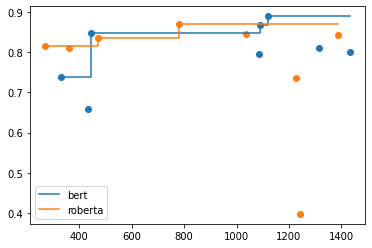

In [4]:
from flaml.data import get_output_from_log
import matplotlib.pyplot as plt
import numpy as np

for each_file_name in ['bert', 'roberta']:
    time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
        get_output_from_log(filename='spooky_' + each_file_name + '.log', time_budget=3000)
    print(len(valid_loss_history))
    plt.scatter(time_history, 1 - np.array(valid_loss_history))
    plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')

plt.legend(['bert', 'roberta'])
plt.show()

## 4. Other Tasks

Besides sequence classification, FLAML currently also supports four other tasks (more tasks are to be supported, which can be found on FLAML's documentation website https://microsoft.github.io/FLAML/docs/Examples/AutoML-NLP):

- sequence regression: predicting a float number from the input sequence, e.g., predicting the rating of a hotel review based on the text content;
- token classification: predicting the label of each token in a sequence, e.g., named entity recognition;
- multiple choice: predicting the best second half of a sentence that comes next to the first part of a sentence based on common sensen reasoning. An example is seen below;
- (abstractive) summarization: generating the textual summarization of an input paragraph;

For each task, you only have to change the "Load data and preprocess" with the corresponding data loading process. For example:

### 4.1 Multiple Choice Example

Multiple choice is a task of predicting the best second half of a sentence that follows the first half based on common sense reasoning. An example of multiple-choice classification problem is:

On stage, a woman takes a seat at the piano. She
a) sits on a bench as her sister plays with the doll.
b) smiles with someone as the music plays.
c) is in the crowd, watching the dancers.
d) *nervously sets her fingers on the keys*.

In [12]:
from datasets import load_dataset

train_dataset = load_dataset("swag", split="train").to_pandas().iloc[:10000]
dev_dataset = load_dataset("swag", split="validation").to_pandas().iloc[:10000]
test_dataset = load_dataset("swag", split="test").to_pandas()

custom_sent_keys = [
        "sent1",
        "sent2",
        "ending0",
        "ending1",
        "ending2",
        "ending3",
        "gold-source",
        "video-id",
        "startphrase",
        "fold-ind",
    ]                                                  # specify the column names of the input sentences
label_key = "label"                                    # specify the column name of the label

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)
No config specified, defaulting to: swag/regular
Reusing dataset swag (/home/xliu127/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)


In [7]:
train_dataset.iloc[0]["sent1"]

'Members of the procession walk down the street holding small horn brass instruments.'

In [13]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

if not ray.is_initialized():
    ray.init()

automl_settings = {
    "time_budget": 500,                 # setting the time budget
    "task": "multichoice-classification",       # setting the task as multiplechoice-classification
    "fit_kwargs_by_estimator": {          # if model_path is not set, the default model is facebook/muppet-roberta-base: https://huggingface.co/facebook/muppet-roberta-base
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "per_device_eval_batch_size": 16, # the batch size for validation (inference)
        }
    },
    "gpu_per_trial": 1,                 # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",    # set the file to save the log for HPO
    "log_type": "all",                  # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},                    # set whether to use Ray
    "n_concurrent_trials": 4
}

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=86157) {'eval_loss': 0.6315866112709045, 'eval_automl_metric': 0.18779999999999997, 'eval_runtime': 15.4883, 'eval_samples_per_second': 645.648, 'eval_steps_per_second': 40.353, 'epoch': 1.66}
(train pid=86157) {'train_runtime': 190.7625, 'train_samples_per_second': 87.254, 'train_steps_per_second': 10.909, 'train_loss': 0.5091343906738046, 'epoch': 1.66}
(train pid=86249) {'eval_loss': 1.2118068933486938, 'eval_automl_metric': 0.2015, 'eval_runtime': 15.2585, 'eval_samples_per_second': 655.374, 'eval_steps_per_second': 40.961, 'epoch': 2.87}


(train pid=86157) Using amp half precision backend
(train pid=86157) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: ending3, ending1, video-id, sent1, ending0, sent2, fold-ind, ending2, startphrase, gold-source. If ending3, ending1, video-id, sent1, ending0, sent2, fold-ind, ending2, startphrase, gold-source are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86157) ***** Running Prediction *****
(train pid=86157)   Num examples = 10000
(train pid=86157)   Batch size = 16


(train pid=86249) {'eval_loss': 1.2118068933486938, 'eval_automl_metric': 0.2015, 'eval_runtime': 15.1369, 'eval_samples_per_second': 660.639, 'eval_steps_per_second': 41.29, 'epoch': 2.87}
(train pid=86249) {'train_runtime': 546.3809, 'train_samples_per_second': 156.658, 'train_steps_per_second': 39.165, 'train_loss': 0.5030154804349909, 'epoch': 2.87}
(train pid=86195) {'loss': 0.4854, 'learning_rate': 1.3592147782116173e-06, 'epoch': 2.0}


(train pid=86249) Using amp half precision backend
(train pid=86249) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: fold-ind, sent2, gold-source, ending1, startphrase, sent1, ending0, video-id, ending2, ending3. If fold-ind, sent2, gold-source, ending1, startphrase, sent1, ending0, video-id, ending2, ending3 are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86249) ***** Running Prediction *****
(train pid=86249)   Num examples = 10000
(train pid=86249)   Batch size = 16


(train pid=86195) {'eval_loss': 0.49709731340408325, 'eval_automl_metric': 0.17600000000000005, 'eval_runtime': 15.4983, 'eval_samples_per_second': 645.232, 'eval_steps_per_second': 40.327, 'epoch': 2.0}


2022-03-19 14:41:56,719	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86195) {'eval_loss': 0.5254333019256592, 'eval_automl_metric': 0.17800000000000005, 'eval_runtime': 15.45, 'eval_samples_per_second': 647.251, 'eval_steps_per_second': 40.453, 'epoch': 3.0}
(train pid=86195) {'loss': 0.3989, 'learning_rate': 3.8051750127352887e-07, 'epoch': 3.0}


2022-03-19 14:42:56,729	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86195) {'eval_loss': 0.5254867076873779, 'eval_automl_metric': 0.17789999999999995, 'eval_runtime': 15.424, 'eval_samples_per_second': 648.341, 'eval_steps_per_second': 40.521, 'epoch': 3.0}
(train pid=86195) {'eval_loss': 0.5332269072532654, 'eval_automl_metric': 0.17830000000000001, 'eval_runtime': 15.4452, 'eval_samples_per_second': 647.45, 'eval_steps_per_second': 40.466, 'epoch': 3.39}
(train pid=86195) {'train_runtime': 382.2827, 'train_samples_per_second': 88.597, 'train_steps_per_second': 11.076, 'train_loss': 0.5299136270370808, 'epoch': 3.39}


2022-03-19 14:43:56,739	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86195) Using amp half precision backend
(train pid=86195) The following columns in the test set  don't have a corresponding argument in `RobertaForMultipleChoice.forward` and have been ignored: ending2, sent1, ending0, sent2, ending3, video-id, gold-source, ending1, startphrase, fold-ind. If ending2, sent1, ending0, sent2, ending3, video-id, gold-source, ending1, startphrase, fold-ind are not expected by `RobertaForMultipleChoice.forward`,  you can safely ignore this message.
(train pid=86195) ***** Running Prediction *****
(train pid=86195)   Num examples = 10000
(train pid=86195)   Batch size = 16
2022-03-19 14:44:14,271	INFO tune.py:639 -- Total run time: 795.18 seconds (504.18 seconds for the tuning loop).
[flaml.automl: 03-19 14:44:19] {2837} INFO - selected model: None
/data/installation/anaconda3/envs/tmp/lib

{'loss': 0.6603, 'learning_rate': 4.631567529441369e-06, 'epoch': 1.0}


[flaml.automl: 03-19 14:46:08] {2947} INFO - retrain transformer for 109.2s
[flaml.automl: 03-19 14:46:08] {2954} INFO - retrained model: None
[flaml.automl: 03-19 14:46:08] {2283} INFO - fit succeeded
[flaml.automl: 03-19 14:46:08] {2284} INFO - Time taken to find the best model: 319.927033662796


{'train_runtime': 96.899, 'train_samples_per_second': 245.031, 'train_steps_per_second': 30.63, 'train_loss': 0.6602518278346073, 'epoch': 1.0}


{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 0.00021956991427751982, 'num_train_epochs': 0.3549576494055084, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.07425273520338253, 'weight_decay': 0.03879221030529465, 'adam_epsilon': 3.7880482987985576e-08, 'seed': 43, 'global_max_steps': 444, 'learner': 'transformer'}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 0.00021956991427751982, 'num_train_epochs': 0.3549576494055084, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.07425273520338253, 'weight_decay': 0.03879221030529465, 'adam_epsilon': 3.7880482987985576e-08, 'seed': 43, 'global_max_steps': 444, 'learner': 'transformer'}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, 'weight_decay': 0.0, 'adam_epsilon': 1e-06, 'seed': 42, '

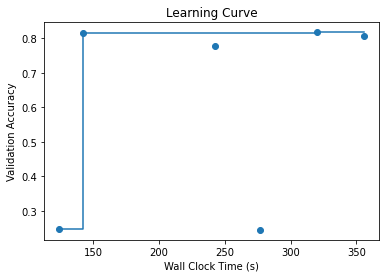

In [14]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

### 4.2 Text Summarization Example

The text summarization task summarizes a long text into a short sentence. For example:

- Document: Army explosives experts were called out to deal with a suspect package at the offices on the Newtownards Road on Friday night. Roads were sealed off and traffic diverted as a controlled explosion was carried out. The premises, used by East Belfast MP Naomi Long, have been targeted a number of times. Most recently, petrol bomb attacks were carried out on the offices on consecutive nights in April and May. The attacks began following a Belfast City Council vote in December 2012 restricting the flying of the union flag at the City Hall. Condemning the latest hoax, Alliance MLA Chris Lyttle said: "It is a serious incident for the local area, it causes serious disruption, it puts people's lives at risk, it can prevent emergency services reaching the area. "Ultimately we need people with information to share that with the police in order for them to do their job and bring these people to justice.

- Summary: A suspicious package left outside an Alliance Party office in east Belfast has been declared a hoax.

In this example, we use FLAML to perform *abstractive summarization* using the t5-small language model, i.e., the summary is generated word-by-word. 

In [15]:
from datasets import load_dataset

train_dataset = load_dataset("xsum", split="train").to_pandas()
print(len(train_dataset))
dev_dataset = load_dataset("xsum", split="validation").to_pandas()
test_dataset = load_dataset("xsum", split="test").to_pandas()

custom_sent_keys = ["document"]       # specify the column names of the input sentences
label_key = "summary"                 # specify the column name of the label                              

X_train, y_train = train_dataset[custom_sent_keys], train_dataset[label_key]
X_val, y_val = dev_dataset[custom_sent_keys], dev_dataset[label_key]
X_test = test_dataset[custom_sent_keys]

Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


204045


Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)
Using custom data configuration default
Reusing dataset xsum (/home/xliu127/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


In [16]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

import ray
if not ray.is_initialized():
    ray.init()

automl_settings = {
    "time_budget": 500,         # setting the time budget
    "task": "summarization",    # setting the task as summarization
    "fit_kwargs_by_estimator": {  # if model_path is not set, the default model is t5-small: https://huggingface.co/t5-small
        "transformer": {
            "output_dir": "data/output/",  # setting the output directory
            "model_path": "t5-small",
            "per_device_eval_batch_size": 16,  # the batch size for validation (inference)
        }
    },
    "gpu_per_trial": 1,  # set to 0 if no GPU is available
    "log_file_name": "seqclass.log",  # set the file to save the log for HPO
    "log_type": "all",   # the log type for trials: "all" if logging all the trials, "better" if only keeping the better trials
    "use_ray": {"local_dir": "data/output/"},  # set whether to use Ray
    "metric": "rouge1",
    "n_concurrent_trials": 4,  # sample: False # if the time is sufficient (e.g., longer than one trial's running time), you can set 
}

'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, **automl_settings)

(train pid=86232) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86232)   warnings.warn(


(train pid=86232) {'loss': 8.7635, 'learning_rate': 1.2308416834153697e-05, 'epoch': 0.11}


(train pid=86184) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86184)   warnings.warn(
(train pid=86225) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train pid=86225)   warnings.warn(
(train pid=86160) /data/installation/anaconda3/envs/tmp/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.opti

(train pid=86232) {'eval_loss': 6.893245697021484, 'eval_automl_metric': 0.8537338408275918, 'eval_runtime': 102.2734, 'eval_samples_per_second': 110.801, 'eval_steps_per_second': 6.932, 'epoch': 0.11}


2022-03-19 14:57:00,687	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86184) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86184) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'eval_loss': 7.381210803985596, 'eval_automl_metric': 0.8475751825208984, 'eval_runtime': 107.4032, 'eval_samples_per_second': 105.509, 'eval_steps_per_second': 6.601, 'epoch': 0.16}


(train pid=86160) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86160) [nltk_data]   Package punkt is already up-to-date!
(train pid=86225) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86225) [nltk_data]   Package punkt is already up-to-date!


(train pid=86160) {'eval_loss': 10.150897979736328, 'eval_automl_metric': 0.8566791839938478, 'eval_runtime': 108.2143, 'eval_samples_per_second': 104.718, 'eval_steps_per_second': 6.552, 'epoch': 0.36}


2022-03-19 14:58:00,697	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.


(train pid=86225) {'eval_loss': 11.665904998779297, 'eval_automl_metric': 0.858011676038827, 'eval_runtime': 109.4667, 'eval_samples_per_second': 103.52, 'eval_steps_per_second': 6.477, 'epoch': 0.38}


(train pid=86232) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86232) [nltk_data]   Package punkt is already up-to-date!


(train pid=86232) {'eval_loss': 6.893245697021484, 'eval_automl_metric': 0.8537338408275918, 'eval_runtime': 110.7246, 'eval_samples_per_second': 102.344, 'eval_steps_per_second': 6.403, 'epoch': 0.11}
(train pid=86232) {'train_runtime': 220.8946, 'train_samples_per_second': 4.648, 'train_steps_per_second': 0.149, 'train_loss': 8.763471198804451, 'epoch': 0.11}


2022-03-19 14:59:00,706	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86232) Using amp half precision backend
(train pid=86232) ***** Running Prediction *****
(train pid=86232)   Num examples = 11332
(train pid=86232)   Batch size = 16
(train pid=86184) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86184) [nltk_data]   Package punkt is already up-to-date!
(train pid=86160) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86160) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'eval_loss': 7.381210803985596, 'eval_automl_metric': 0.8475751825208984, 'eval_runtime': 109.1975, 'eval_samples_per_second': 103.775, 'eval_steps_per_second': 6.493, 'epoch': 0.16}


(train pid=86225) [nltk_data] Downloading package punkt to /home/xliu127/nltk_data...
(train pid=86225) [nltk_data]   Package punkt is already up-to-date!


(train pid=86184) {'train_runtime': 232.9303, 'train_samples_per_second': 10.067, 'train_steps_per_second': 1.262, 'train_loss': 9.880440506280637, 'epoch': 0.16}
(train pid=86160) {'eval_loss': 10.150897979736328, 'eval_automl_metric': 0.8566791839938478, 'eval_runtime': 108.3182, 'eval_samples_per_second': 104.618, 'eval_steps_per_second': 6.546, 'epoch': 0.36}
(train pid=86160) {'train_runtime': 232.4568, 'train_samples_per_second': 92.218, 'train_steps_per_second': 2.887, 'train_loss': 11.215172903878349, 'epoch': 0.36}
(train pid=86225) {'eval_loss': 11.665904998779297, 'eval_automl_metric': 0.858011676038827, 'eval_runtime': 110.526, 'eval_samples_per_second': 102.528, 'eval_steps_per_second': 6.415, 'epoch': 0.38}
(train pid=86225) {'train_runtime': 236.6253, 'train_samples_per_second': 19.714, 'train_steps_per_second': 0.621, 'train_loss': 11.549961930614407, 'epoch': 0.38}


2022-03-19 15:00:00,942	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
(train pid=86184) Using amp half precision backend
(train pid=86184) ***** Running Prediction *****
(train pid=86184)   Num examples = 11332
(train pid=86184)   Batch size = 16
(train pid=86160) Using amp half precision backend
(train pid=86160) ***** Running Prediction *****
(train pid=86160)   Num examples = 11332
(train pid=86160)   Batch size = 16
(train pid=86225) Using amp half precision backend
(train pid=86225) ***** Running Prediction *****
(train pid=86225)   Num examples = 11332
(train pid=86225)   Batch size = 16
2022-03-19 15:01:00,948	WARNING ray_trial_executor.py:146 -- Skipping cleanup - trainable.stop did not return in time. Consider making `stop` a faster operation.
2022-03-19 15:02:20,150	INFO tune.py:639 -- Total run time: 950.87 seconds (500.36 seconds for the tuning loop).
[flaml.automl: 03-19 15:02:25] {

{'train_runtime': 14.6848, 'train_samples_per_second': 13894.959, 'train_steps_per_second': 434.258, 'train_loss': 10.199760437011719, 'epoch': 0.02}


{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 3.6439277745413994e-06, 'num_train_epochs': 0.454119690781029, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04654549348562217, 'weight_decay': 0.06669806327326033, 'adam_epsilon': 2.5833461668835812e-08, 'seed': 42, 'global_max_steps': 125, 'learner': 'transformer', 'FLAML_sample_size': 10000}, 'Best Learner': 'transformer', 'Best Hyper-parameters': {'learning_rate': 3.6439277745413994e-06, 'num_train_epochs': 0.454119690781029, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.04654549348562217, 'weight_decay': 0.06669806327326033, 'adam_epsilon': 2.5833461668835812e-08, 'seed': 42, 'global_max_steps': 125, 'learner': 'transformer', 'FLAML_sample_size': 10000}}
{'Current Learner': 'transformer', 'Current Sample': 10000, 'Current Hyper-parameters': {'learning_rate': 1.0000000000000003e-05, 'num_train_epochs': 1.0, 'per_device_train_batch_size': 32, 'warmup_ratio': 0.0, '

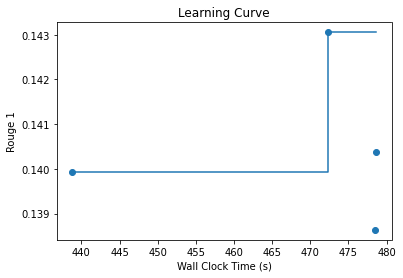

In [17]:

from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=automl_settings['log_file_name'], time_budget=3000)
for config in config_history:
    print(config)

import matplotlib.pyplot as plt
import numpy as np
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Rouge 1')
print(len(valid_loss_history))
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()